## Sound devices

In [2]:
import sounddevice as sd
sd.query_devices()

   0 HDA Intel PCH: CX20632 Analog (hw:0,0), ALSA (2 in, 0 out)
   1 HDA Intel PCH: CX20632 Alt Analog (hw:0,2), ALSA (2 in, 0 out)
   2 HDA Intel PCH: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   3 HDA Intel PCH: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   4 HDA Intel PCH: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   5 HDA Intel PCH: HDMI 3 (hw:0,9), ALSA (0 in, 8 out)
   6 HDA Intel PCH: HDMI 4 (hw:0,10), ALSA (0 in, 8 out)
   7 HD Pro Webcam C920: USB Audio (hw:1,0), ALSA (2 in, 0 out)
   8 sysdefault, ALSA (128 in, 0 out)
   9 hdmi, ALSA (0 in, 8 out)
  10 samplerate, ALSA (128 in, 0 out)
  11 speexrate, ALSA (128 in, 0 out)
  12 pulse, ALSA (32 in, 32 out)
  13 upmix, ALSA (8 in, 0 out)
  14 vdownmix, ALSA (6 in, 0 out)
* 15 default, ALSA (32 in, 32 out)

## Postprocessing

In [110]:
import os, h5py
import numpy as np
from modules.postprocessing import pack

ModuleNotFoundError: No module named 'modules'

In [111]:
source = '/home/sobolev/nevermind/Andrey/data'
#source = 'Z:\\Andrey\\data'
animal = '008229'
session = '008229_hippoSIT_2022-06-09_14-15-49'

session_path = os.path.join(source, animal, session)
h5name = pack(session_path)

NameError: name 'pack' is not defined

In [8]:
with h5py.File(h5name, 'r') as f:
    islands = np.array(f['raw']['islands'])

## Reading .spk

In [112]:
def get_wf_metrics(wf):
    idx_tr = np.argmin(wf)  # idx of trough
    if idx_tr > 0:
        peak_l_idx = np.argmax(wf[:idx_tr])
        peak_r_idx = np.argmax(wf[idx_tr:]) + idx_tr
        amp = wf[peak_l_idx] - wf.min()  # spike amplitude
        width = idx_tr - peak_l_idx  # spike width
        return amp, width
    else:
        return 0, 0

In [113]:
def get_unit_idxs(units):
    idxs = np.zeros(0, dtype=np.int16)
    for unit in units:
        idxs = np.concatenate([idxs, np.where(cluster_map == unit)[0]])
    return idxs

In [114]:
import os
import numpy as np

source  = '/home/sobolev/nevermind/Andrey/data'
session = '009266_hippoSIT_2023-06-21_08-15-10'
animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
spk_file = os.path.join(sessionpath, session + '.spk.3')
clu_file = os.path.join(sessionpath, session + '.clu.3')

In [115]:
block = np.fromfile(spk_file, dtype=np.int16)
cluster_map = np.loadtxt(clu_file, dtype=np.uint16)

channels_no = 8
samples_no  = 50
spikes_no   = int(block.shape[0]/(channels_no*samples_no))

b1 = block.reshape([spikes_no, samples_no, channels_no])
b1.shape

(116716, 50, 8)

In [116]:
block.shape

(46686400,)

In [466]:
idxs = get_unit_idxs([14, 16])  # selected units

b2 = b1[idxs]
b2.shape

(5425, 50, 8)

In [467]:
# save the waveforms as .npy
np.save('waveforms.npy', b2)

## Mean spike waveforms

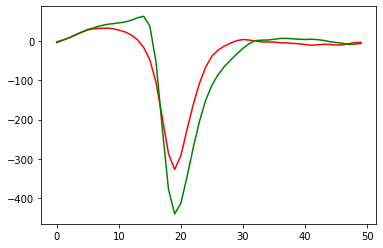

In [413]:
for ch in [7]:
    plt.plot(b1[:, :, ch][get_unit_idxs([14])].mean(axis=0), color='red')
    plt.plot(b1[:, :, ch][get_unit_idxs([16])].mean(axis=0), color='green')

In [418]:
idxs = get_unit_idxs([14, 16])

spk_metrics = np.zeros((len(idxs), 2))
for i, wf in enumerate(b1[:, :, 6][idxs]): # taking channel 7
    spk_metrics[i] = np.array(get_wf_metrics(wf))

(0.0, 30.0)

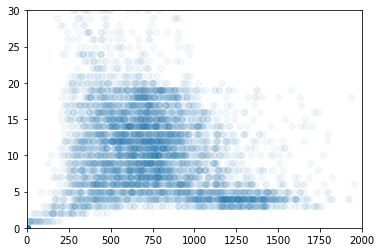

In [419]:
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], alpha=0.05)
plt.xlim(0, 2000)
plt.ylim(0, 30)

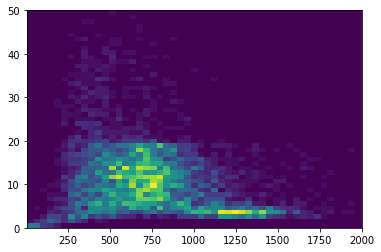

In [280]:
_ = plt.hist2d(spk_metrics[:, 0], spk_metrics[:, 1], bins=[np.linspace(5, 2000, 50), np.linspace(0, 50, 50)])

In [375]:
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, init_params='kmeans').fit_predict(spk_metrics)

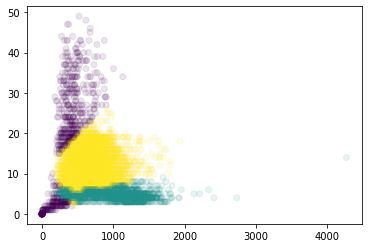

In [376]:
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], c=y_pred, alpha=0.1)

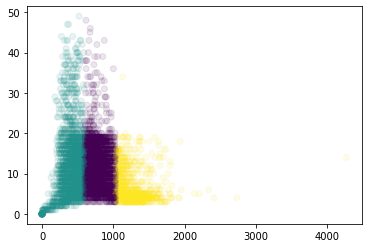

In [424]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit_predict(spk_metrics)
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], c=kmeans, alpha=0.1)

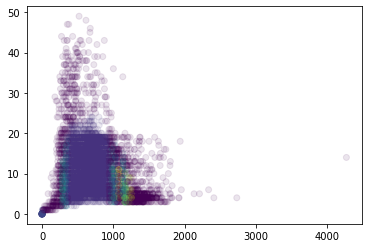

In [425]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=6, min_samples=25).fit(spk_metrics)
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], c=clustering.labels_, alpha=0.1)
#plt.xlim(0, 1500)

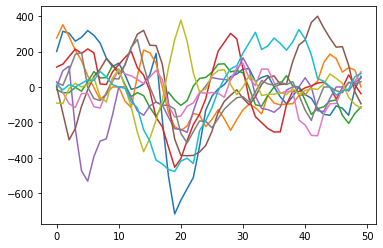

In [235]:
import matplotlib.pyplot as plt


for spk in b1[:, :, 5][idxs[:10]]:
    _ = plt.plot(spk)

In [421]:
from sklearn import decomposition

selection = b1[:, :, 6][idxs]

pca = decomposition.PCA(n_components=3)
pca.fit(selection)
X = pca.transform(selection)

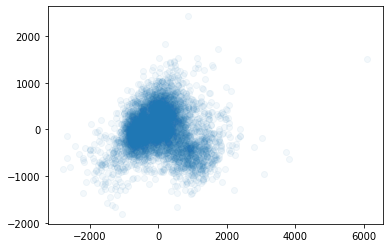

In [423]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.05)

In [448]:
y_pred

array([1, 0, 1, ..., 0, 0, 0])

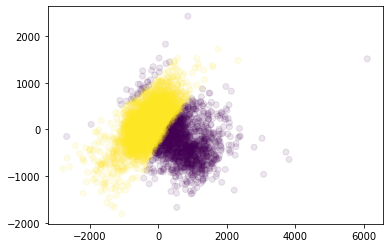

In [447]:
y_pred = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(X[:, :2])
plt.scatter(X[:, 0], X[:, 1], c=y_pred, alpha=0.1)

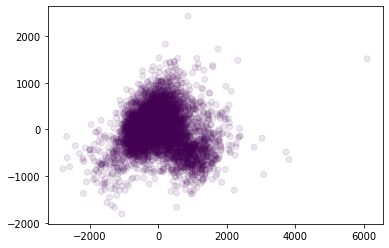

In [441]:
# try DBSCAN !

In [452]:
b1.shape

(116716, 50, 8)

In [453]:
# building feature vectors for all channels
spk_fet = np.zeros((len(idxs), 2*b1.shape[2]))

for i, idx in enumerate(idxs):  # iterate over spikes
    for ch in range(8):  # iterate over channels
        wf = b1[idx, :, ch]
        amp, width = get_wf_metrics(wf)
        spk_fet[i, ch*2] = amp
        spk_fet[i, ch*2 + 1] = width

In [455]:
pca = decomposition.PCA(n_components=3)
pca.fit(spk_fet)
Z = pca.transform(spk_fet)

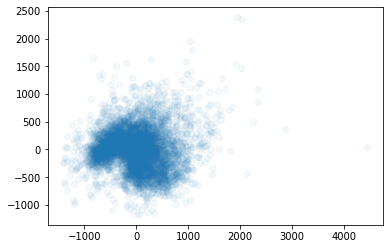

In [459]:
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.05)

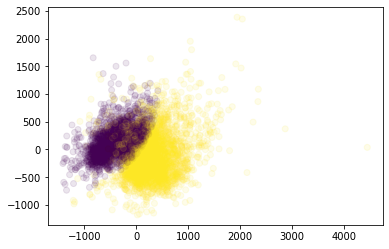

In [463]:
y_pred = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(Z)
plt.scatter(Z[:, 0], Z[:, 1], c=y_pred, alpha=0.1)

## Applying PCA on spike waveforms

In [449]:
# flattening waveforms across channels
b2 = np.zeros((b1.shape[0], b1.shape[1]*b1.shape[2])) 
for i, spk2D in enumerate(b1):
    b2[i] = spk2D.T.flatten()

In [450]:
b2.shape

(116716, 400)

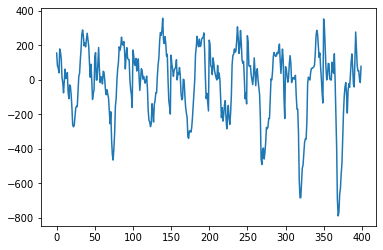

In [63]:
plt.plot(b2[1000])

In [64]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
pca.fit(b2)
X = pca.transform(b2)

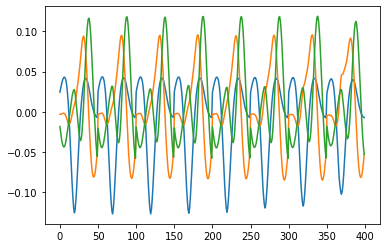

In [66]:
fig, ax = plt.subplots(1, 1)
ax.plot(pca.components_[0])
ax.plot(pca.components_[1])
ax.plot(pca.components_[2])

(array([[ 0.,  1.,  0., ...,  3.,  1.,  4.],
        [ 0.,  1.,  0., ...,  0.,  1.,  2.],
        [ 0.,  0.,  0., ...,  0.,  4.,  0.],
        ...,
        [ 3., 10.,  5., ...,  6.,  7.,  6.],
        [ 5.,  6., 10., ...,  7.,  3.,  6.],
        [ 4.,  7.,  4., ...,  3.,  2.,  7.]]),
 array([-7500.        , -7244.89795918, -6989.79591837, -6734.69387755,
        -6479.59183673, -6224.48979592, -5969.3877551 , -5714.28571429,
        -5459.18367347, -5204.08163265, -4948.97959184, -4693.87755102,
        -4438.7755102 , -4183.67346939, -3928.57142857, -3673.46938776,
        -3418.36734694, -3163.26530612, -2908.16326531, -2653.06122449,
        -2397.95918367, -2142.85714286, -1887.75510204, -1632.65306122,
        -1377.55102041, -1122.44897959,  -867.34693878,  -612.24489796,
         -357.14285714,  -102.04081633,   153.06122449,   408.16326531,
          663.26530612,   918.36734694,  1173.46938776,  1428.57142857,
         1683.67346939,  1938.7755102 ,  2193.87755102,  2448.97959

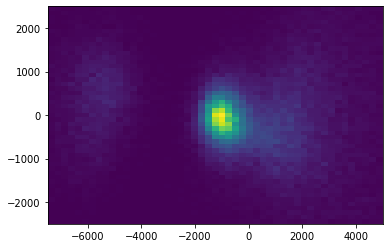

In [79]:
plt.hist2d(X[:, 0], X[:, 2], bins=[np.linspace(-7500, 5000, 50), np.linspace(-2500, 2500, 50)])

In [1]:
import pandas
human_data = pandas.read_csv('https://content.labxchange.org/labs/datasets/CodeSciLab/HumanHeightWeightData.csv')

## Patch CSV files

In [19]:
import sys, os
import numpy as np
from analysis.imports import *

session = '009265_hippoSIT_2023-03-10_09-57-34'

path_src = os.path.join(source, '009265', session, 'sounds.csv')
path_dst = os.path.join(source, '009265', session, 'sounds1.csv')

data = np.loadtxt(path_src, delimiter=',', skiprows=1)
np.savetxt(path_dst, data[:, [0, 2]], header='time,id', delimiter=',')

## Kilosort staff

In [11]:
import scipy.io
import h5py
import numpy as np

f_path = '/home/sobolev/nevermind/Miguel/SIT_duration/Threshold_optimization/6-14/rez.mat'
#mat = scipy.io.loadmat(f_path)

with h5py.File(f_path, 'r') as f:
    desc = ["%s: %s" % (n, f['rez'][n]) for n in f['rez']]
    for i in desc:
        print(i)

F: <HDF5 dataset "F": shape (824, 20, 58), type "<f8">
F0: <HDF5 dataset "F0": shape (1, 6), type "<u4">
F0m: <HDF5 dataset "F0m": shape (1, 6), type "<u4">
U: <HDF5 dataset "U": shape (6, 41, 32), type "<f4">
W: <HDF5 dataset "W": shape (6, 41, 61), type "<f4">
Wrot: <HDF5 dataset "Wrot": shape (32, 32), type "<f8">
cProj: <HDF5 dataset "cProj": shape (2,), type "<u8">
cProjPC: <HDF5 dataset "cProjPC": shape (2,), type "<u8">
dWU: <HDF5 dataset "dWU": shape (1, 6), type "<u4">
dist: <HDF5 dataset "dist": shape (60, 10), type "<f4">
dshift: <HDF5 dataset "dshift": shape (9, 824), type "<f8">
est_contam_rate: <HDF5 dataset "est_contam_rate": shape (1, 41), type "<f8">
good: <HDF5 dataset "good": shape (1, 41), type "<f8">
iC: <HDF5 dataset "iC": shape (1, 6), type "<u4">
iNeigh: <HDF5 dataset "iNeigh": shape (2,), type "<u8">
iNeighPC: <HDF5 dataset "iNeighPC": shape (2,), type "<u8">
iorig: <HDF5 dataset "iorig": shape (1, 824), type "<f8">
mu: <HDF5 dataset "mu": shape (1, 41), type "

In [37]:
with h5py.File(f_path, 'r') as f:
    st = np.array(f['rez']['st3'])

In [44]:
#np.unique(st[4])

In [55]:
st_path = '/home/sobolev/nevermind/Miguel/SIT_duration/Threshold_optimization/6-14/spike_times.npy'
sc_path = '/home/sobolev/nevermind/Miguel/SIT_duration/Threshold_optimization/6-14/spike_clusters.npy'
tl_path = '/home/sobolev/nevermind/Miguel/SIT_duration/Threshold_optimization/6-14/spike_templates.npy'

s_times = np.load(st_path)
s_clust = np.load(sc_path)
s_templ = np.load(tl_path)

In [56]:
s_templ.T[0]

array([11, 20, 20, ..., 37, 37, 13], dtype=uint32)

In [57]:
s_clust.T[0]

array([11, 20, 20, ..., 37, 37, 13], dtype=uint32)

In [85]:
tp_path = '/home/sobolev/nevermind/Miguel/SIT_duration/Threshold_optimization/6-14/templates.npy'

templates = np.load(tp_path)

In [105]:
templates.shape

(41, 82, 32)

In [103]:
t1 = templates[28]

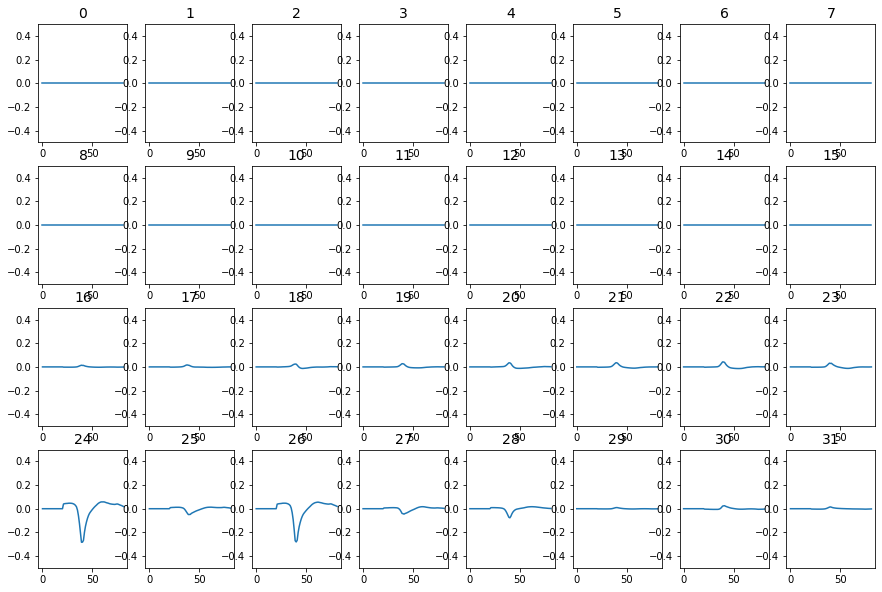

In [104]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))

for i, t in enumerate(t1.T):
    ax = fig.add_subplot(4, 8, i+1)
    ax.plot(t)
    ax.set_ylim(-0.5, 0.5)
    ax.set_title(str(i), fontsize=14)
    
#plt.ylim(-0.02, 0.02)

In [109]:
amplitudes = [t.max() - t.min() for t in t1.T]
np.argmax(amplitudes)

24

## Offset and drift in sounds

In [130]:
import sys, os
import numpy as np
import h5py
from session.sessions import selected_009266, selected_009265
from analysis.imports import *

#session = '009266_hippoSIT_2023-04-17_17-04-17'
#snd_path = os.path.join(source, '009266', session, 'sounds.csv')
selected = selected_009266

pos_diff = np.zeros(len(selected))
aep_diff = np.zeros(len(selected))
snd_diff = np.zeros(len(selected))

for i, session in enumerate(selected):
    if i < 0:
        continue
    animal = session.split('_')[0]
    h5_file  = os.path.join(source, animal, session, session + '.h5')
    aeps_file  = os.path.join(source, animal, session, 'AEPs.h5')
    
    with h5py.File(h5_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
        trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
        cfg = json.loads(f['processed'].attrs['parameters'])

        sounds = np.array(f['raw']['sounds'])
        events = np.array(f['raw']['events'])
        positions = np.array(f['raw']['positions'])
        
    with h5py.File(aeps_file, 'r') as f:
        aeps_events = np.array(f['aeps_events'])  # time, X, Y, speed, etc.
        
    pos_diff[i] = sounds[0][0] - positions[0][0]
    snd_diff[i] = sounds[0][0] - events[0][0]
    aep_diff[i] = aeps_events[1][0]
    
    #print(sounds[0][0] - events[0][0], aeps_events[0][0])
    t_start = events[0][0]
    print(positions[0][0] - t_start, sounds[0][0] - t_start, aeps_events[0][0], aeps_events[1][0])

0.004000425338745117 0.2500143051147461 0.02 0.27002003580255035
-0.002000093460083008 0.24901437759399414 0.01 0.260020082149074
-0.0060002803802490234 0.24601435661315918 0.007 0.25701979678146397
0.0 0.24701404571533203 0.004 0.2540200358025492
0.012000799179077148 0.2480144500732422 0.001 0.2510197973785063
0.0030002593994140625 0.24901413917541504 0.005 0.2550200358025498
0.008000373840332031 0.24901413917541504 0.012 0.2620200358025498
0.006000518798828125 0.24701452255249023 0.01 0.26002008032681523
-0.006000518798828125 0.24601387977600098 0.002 0.2520200358025498
-0.00500035285949707 0.24701404571533203 0.002 0.2520200358025498
-0.005000114440917969 0.24701428413391113 0.014 0.26402008822347667
-0.0020003318786621094 0.2500143051147461 0.015 0.26502003639971716
0.013000726699829102 0.250014066696167 0.021 0.27102003639971717
0.009000539779663086 0.2500143051147461 0.009 0.259020155889891
0.011000871658325195 0.2480144500732422 0.014 0.26401979737850634
-0.005000114440917969 0.

In [144]:
aeps_file  = os.path.join(source, animal, session, 'AEPs.h5')
with h5py.File(aeps_file, 'r') as f:
    aeps_events = np.array(f['aeps_events'])

In [141]:
session  = '009266_hippoSIT_2023-04-17_17-04-17'
dst_path = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
animal = session.split('_')[0]
h5_file  = os.path.join(dst_path, animal, session, 'meta.h5')
aeps_file  = os.path.join(dst_path, animal, session, 'AEPs.h5')

with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    sound_events = np.array(f['processed']['sound_events'])  # time, X, Y, speed, etc.
    sounds = np.array(f['raw']['sounds'])
    events = np.array(f['raw']['events'])

In [142]:
events[0][0], sounds[0][0]

(1681743993.6502788, 1681743993.900293)

In [147]:
sound_events[:, 0][:5], sounds[:, 0][:5] - events[0][0]

(array([0.25001431, 0.50003486, 0.75005542, 1.00007597, 1.25009629]),
 array([0.25001431, 0.50002861, 0.75004292, 1.00005722, 1.25007129]))

In [146]:
aeps_events[:, 0][:5]

array([0.02      , 0.27002004, 0.52004007, 0.77006011, 1.0200799 ])

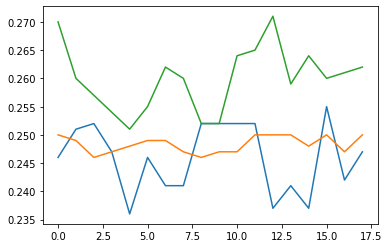

In [93]:
plt.plot(pos_diff)
plt.plot(snd_diff)
#plt.plot(snd_diff + pos_diff)
plt.plot(aep_diff)

In [60]:
tstmp_path1 = '/home/sobolev/nevermind/Andrey/data/009266/009266_hippoSIT_2023-04-17_17-04-17/2023-04-17_17-06-33/Record Node 117/experiment1/recording1/events/Rhythm_FPGA-114.0/TTL_1/timestamps.npy'
tstmp_path2 = '/home/sobolev/nevermind/Andrey/data/009266/009266_hippoSIT_2023-04-17_17-04-17/2023-04-17_17-06-33/Record Node 117/experiment1/recording1/events/Message_Center-904.0/TEXT_group_1/channels.npy'
tstmp_path3 = '/home/sobolev/nevermind/Andrey/data/009266/009266_hippoSIT_2023-04-17_17-04-17/2023-04-17_17-06-33/Record Node 117/experiment1/recording1/continuous/Rhythm_FPGA-114.0/synchronized_timestamps.npy'

tstmp = np.load(tstmp_path3)
tstmp.shape

(71998976,)

(array([1.000e+00, 5.000e+00, 3.300e+01, 0.000e+00, 2.570e+02, 9.128e+03,
        0.000e+00, 1.480e+02, 2.100e+01, 5.000e+00]),
 array([0.24601436, 0.24671438, 0.2474144 , 0.24811442, 0.24881444,
        0.24951446, 0.25021448, 0.2509145 , 0.25161452, 0.25231454,
        0.25301456]),
 <BarContainer object of 10 artists>)

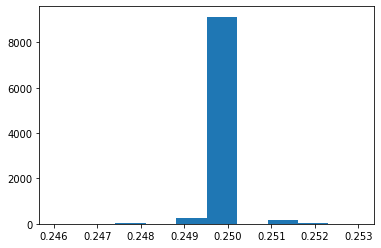

In [99]:
plt.hist(np.diff(sounds[:, 0]))

In [100]:
np.where(sounds[:, 1] == 0)

(array([ 279,  280,  281, ..., 9448, 9449, 9450]),)

In [103]:
sounds[278:290][:, 0] - sounds[0][0]

array([69.5019753 , 69.7519896 , 70.00000358, 70.25001812, 70.50003219,
       70.75004649, 71.00006104, 71.2500751 , 71.50008965, 71.75010371,
       72.00011802, 72.25013256])

In [116]:
drift_coeff = 0.015/600  # 15 ms per 10 minutes
"%.16f" % drift_coeff

'0.0000250000000000'

## Replace s_rate

In [279]:
session  = '009266_hippoSIT_2023-04-17_17-04-17'
session  = '009265_hippoSIT_2023-03-03_16-00-47'
session  = '009266_hippoSIT_2023-04-24_10-08-11'
#session  = '009266_hippoSIT_2023-05-04_19-47-15'
dst_path = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
src_path = '/home/sobolev/nevermind/Andrey/sandbox/data/'
animal = session.split('_')[0]

dat_src_file = os.path.join(src_path, animal, session, session + '.dat')
dat_dst_file = os.path.join(dst_path, animal, session, session + '.dat')
xml_file = os.path.join(dst_path, animal, session, session + '.xml')
aeps_file = os.path.join(dst_path, animal, session, 'AEPs.h5')
lfp_file = os.path.join(dst_path, animal, session, session + '.lfp')
lfp_h5_file = os.path.join(dst_path, animal, session, 'lfp.h5')
meta_file = os.path.join(dst_path, animal, session, 'meta.h5')
man_file = os.path.join(src_path, animal, session, 'manual.json')

In [280]:
with h5py.File(lfp_h5_file, 'r') as f:
    lfp_mx = np.array(f['lfp'])

In [281]:
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])

In [282]:
with open(man_file) as json_file:
    aeps_cfg = json.load(json_file)['AEPs']
aeps_cfg

{'A1': 20, 'PPC': 40}

In [283]:
aep_dur = 0.25  # IPI duration in sec
s_rate  = 1000   # LFP samp rate Hz

for area, channel in aeps_cfg.items():
    lfp = lfp_mx[:, channel]
    dur = int(aep_dur*s_rate)
    
    # constructing AEP matrix
    aeps = np.zeros([len(sound_events), dur])
    for i, event in enumerate(sound_events):
        idx_event = int(event[0]*s_rate)
        aeps[i] = lfp[idx_event:idx_event + dur]
        
    # save AEPs to file
    aeps_name = 'aeps_%d_%d' % (channel, dur)
    with h5py.File(aeps_file, 'a') as f:
        if not area in f:
            f.create_group(area)
        if aeps_name in f[area]:
            del f[area][aeps_name]

        f[area].create_dataset(aeps_name, data=aeps)

In [284]:
aeps_all = {}
with h5py.File(aeps_file, 'r') as f:
    for area, channel in aeps_cfg.items():
        aeps_all[area] = np.array(f[area]['aeps_%d_%d' % (aeps_cfg[area], int(aep_dur*s_rate))])

37

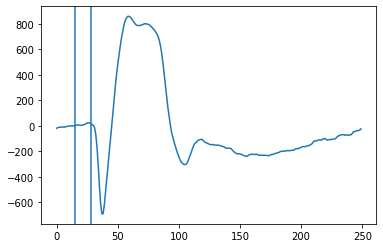

In [285]:
plt.plot(aeps_all['A1'].mean(axis=0))
plt.axvline(15)
plt.axvline(28)

np.argmin(aeps_all['A1'].mean(axis=0))

In [286]:
for session in selected_009266.keys():
    animal = session.split('_')[0]
    meta_file = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(meta_file, 'r') as f:
        positions = np.array(f['raw']['positions'])
        events = np.array(f['raw']['events'])
    
    print(session)
    print(round( positions[0][0] - events[0][0], 5))


009266_hippoSIT_2023-04-17_17-04-17
0.004
009266_hippoSIT_2023-04-18_10-10-37
-0.002
009266_hippoSIT_2023-04-18_17-03-10
-0.006
009266_hippoSIT_2023-04-19_10-33-51
0.0
009266_hippoSIT_2023-04-20_08-57-39
0.012
009266_hippoSIT_2023-04-24_16-56-55
0.003
009266_hippoSIT_2023-04-26_08-20-17
0.008
009266_hippoSIT_2023-05-02_12-22-14
0.006
009266_hippoSIT_2023-05-04_19-47-15
-0.006
009266_hippoSIT_2023-04-20_15-24-14
-0.005
009266_hippoSIT_2023-04-21_08-43-00
-0.005
009266_hippoSIT_2023-04-21_13-12-31
-0.002
009266_hippoSIT_2023-04-24_10-08-11
0.013
009266_hippoSIT_2023-05-22_09-27-22
0.009
009266_hippoSIT_2023-05-23_09-18-05
0.011
009266_hippoSIT_2023-05-25_15-55-57
-0.005
009266_hippoSIT_2023-06-14_08-21-23
0.005
009266_hippoSIT_2023-06-19_08-58-35
0.003


In [ ]:
17, -13, 21
1, 6, 2

In [287]:
for session in selected_009266.keys():
    print(session)

009266_hippoSIT_2023-04-17_17-04-17
009266_hippoSIT_2023-04-18_10-10-37
009266_hippoSIT_2023-04-18_17-03-10
009266_hippoSIT_2023-04-19_10-33-51
009266_hippoSIT_2023-04-20_08-57-39
009266_hippoSIT_2023-04-24_16-56-55
009266_hippoSIT_2023-04-26_08-20-17
009266_hippoSIT_2023-05-02_12-22-14
009266_hippoSIT_2023-05-04_19-47-15
009266_hippoSIT_2023-04-20_15-24-14
009266_hippoSIT_2023-04-21_08-43-00
009266_hippoSIT_2023-04-21_13-12-31
009266_hippoSIT_2023-04-24_10-08-11
009266_hippoSIT_2023-05-22_09-27-22
009266_hippoSIT_2023-05-23_09-18-05
009266_hippoSIT_2023-05-25_15-55-57
009266_hippoSIT_2023-06-14_08-21-23
009266_hippoSIT_2023-06-19_08-58-35


## Create a test dat file

In [237]:
def read_block_from_dat(dat_file, ch_no, offset, bytes_count):
    """
    dat_file      path to the .dat file
    ch_no         total channel number, e.g. 64
    offset        in samples
    bytes_count   number of bytes to read
    """
    count = bytes_count * ch_no  # number of values to read
    offset_in_bytes = offset * ch_no * 2  # assuming int16 is 2 bytes
    block = np.fromfile(dat_file, dtype=np.int16, count=count, offset=offset_in_bytes)
    return block.reshape([bytes_count, ch_no])

In [238]:
block = read_block_from_dat(dat_src_file, 64, 0, 30000 * 60)

In [239]:
np.save(dat_dst_file, block)

## Update events

In [292]:
dst_path = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
session = list(selected_009266.keys())[0]

animal = session.split('_')[0]

meta_file = os.path.join(dst_path, animal, session, 'meta.h5')
man_file  = os.path.join(source, animal, session, 'manual.json')
with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    
sound_events[:, 0][0]

0.2650143051147461

In [291]:
with open(man_file) as json_file:
    offset = json.load(json_file)['ephys']['offset']

sound_events[:, 0] = sound_events[:, 0] + offset/1000.

with h5py.File(meta_file, 'a') as f:
    del f['processed']['sound_events']
    f['processed'].create_dataset('sound_events', data=sound_events)

In [294]:
p1 = '/home/sobolev/nevermind/AG_Pecka/data/processed/meta.xml'

In [295]:
os.path.dirname(p1)

'/home/sobolev/nevermind/AG_Pecka/data/processed'

In [299]:
where = '/home/sobolev/nevermind/AG_Pecka/sandbox/data/processed/009266/009266_hippoSIT_2023-04-17_17-04-17/neurosuite'
clu_files = [f for f in os.listdir(where) if f.find('.clu.') > 0]

## Create manual.json files

In [1]:
import sys, os
import numpy as np
import h5py, json
from session.sessions import selected_009266, selected_009265, selected_008229
from analysis.imports import *

src_path = '/home/sobolev/nevermind/Andrey/data/'

In [2]:
for i, (session, desc) in enumerate(selected_008229.items()):
    animal = session.split('_')[0]
    s_path = os.path.join(src_path, animal, session)
    man_file = os.path.join(s_path, 'manual.json')
    
    with open(man_file, 'w') as f:
        json.dump(desc, f, indent=4)

## Update offset in manual.json files

In [11]:
# ALL DONE!
import os, json
src_path = '/home/sobolev/nevermind/AG_Pecka/data/raw'
animal = '009265'

for session in os.listdir(os.path.join(src_path, animal)):
    json_file = os.path.join(src_path, animal, session, 'manual.json')
    
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    offset = int(data['ephys']['offset'])
    data['ephys']['offset'] = offset + 5
    
    #with open(json_file, 'w', encoding='utf-8') as f:
    #    json.dump(data, f, ensure_ascii=False, indent=4)
    
    print('%s: old - %d, new - %d' % (session, offset, data['ephys']['offset']))

009265_hippoSIT_2023-02-24_09-53-26: old - 116, new - 121
009265_hippoSIT_2023-02-24_17-22-46: old - 134, new - 139
009265_hippoSIT_2023-02-27_10-18-32: old - 97, new - 102
009265_hippoSIT_2023-02-27_15-33-46: old - 107, new - 112
009265_hippoSIT_2023-02-28_09-16-50: old - 101, new - 106
009265_hippoSIT_2023-02-28_13-16-10: old - 104, new - 109
009265_hippoSIT_2023-02-28_20-45-04: old - 103, new - 108
009265_hippoSIT_2023-03-01_10-46-12: old - 101, new - 106
009265_hippoSIT_2023-03-02_09-32-54: old - 105, new - 110
009265_hippoSIT_2023-03-02_16-27-42: old - 124, new - 129
009265_hippoSIT_2023-03-02_20-11-35: old - 105, new - 110
009265_hippoSIT_2023-03-03_09-37-07: old - 95, new - 100
009265_hippoSIT_2023-03-03_16-00-47: old - 111, new - 116
009265_hippoSIT_2023-03-04_11-12-04: old - 93, new - 98
009265_hippoSIT_2023-03-05_11-52-17: old - 108, new - 113


## Copy neurosuite files

In [13]:
import shutil

src_path = '/home/sobolev/nevermind/Andrey/data/'
dst_path = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

for session in list(selected_008229.keys()):
    animal = session.split('_')[0]
    s_path = os.path.join(src_path, animal, session)
    
    for ext in ['spk', 'res', 'fet', 'klg', 'clu']:
        for f_name in [f for f in os.listdir(s_path) if f.find('.%s.' % ext) > 0]:
            if len(f_name) > 50:
                continue
            src_file = os.path.join(src_path, animal, session, f_name)
            dst_file = os.path.join(dst_path, animal, session, 'neurosuite', f_name)
            shutil.copyfile(src_file, dst_file)
    print(session)

008229_hippoSIT_2022-05-17_21-44-43
008229_hippoSIT_2022-05-16_20-36-44
008229_hippoSIT_2022-05-20_15-54-39
008229_hippoSIT_2022-05-18_14-36-18


## Speaker numbers

In [6]:
import os
import json

source = '/home/sobolev/nevermind/Andrey/data'
animal = '009265'

sessions = [x for x in os.listdir(os.path.join(source, animal)) if os.path.isdir(os.path.join(source, animal, x))]
sessions.sort()

for session in sessions:
    json_file = os.path.join(source, animal, session, session + '.json')
    if os.path.exists(json_file):
        with open(json_file) as f:
            cfg = json.load(f)
            
    bgr_ch = cfg['sound']['sounds']['background']['channels']
    tgt_ch = cfg['sound']['sounds']['target']['channels']
    print("%s: BGR: %s, TGT: %s" % (session, bgr_ch, tgt_ch))

009265_hippoSIT_2023-02-21_20-44-17: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-22_08-50-47: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-22_15-22-30: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-23_09-08-17: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-23_15-24-36: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-24_09-53-26: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-24_17-22-46: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-27_10-18-32: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-27_15-33-46: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-28_09-16-50: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-28_13-16-10: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-02-28_20-45-04: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-03-01_10-46-12: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-03-02_09-32-54: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-03-02_16-27-42: BGR: [1, 8], TGT: [3, 8]
009265_hippoSIT_2023-03-02_20-11-35: BGR: [1, 8], TGT: [3, 8]
009265_h

## New plotting

In [11]:
import sys, os
import h5py
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *

In [12]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [15]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
session  = sessions[0]
animal   = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])
    
# load units
unit_names, single_units, spike_times, spike_idxs = [], {}, {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]

with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
        spike_idxs[unit_name] = np.array(f[unit_name][H5NAMES.spike_idxs['name']])
        fr_map = 

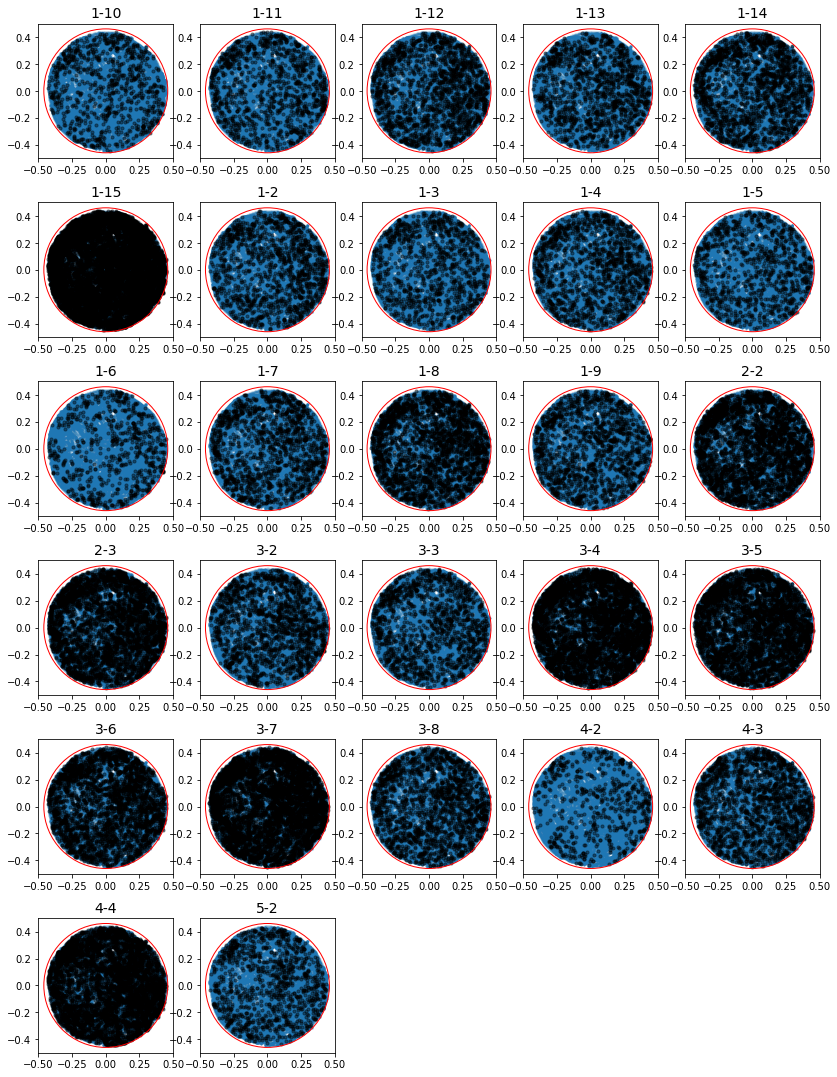

In [25]:
limits = (-0.5, 0.5, -0.5, 0.5)
cols = 5
rows = int(np.ceil(len(unit_names)/cols))
fig = plt.figure(figsize=(14, rows*3.2))

for i, unit_name in enumerate(unit_names):
    run_idxs = np.where(tl[:, 3] > 0.04)[0]
    
    # animal positions
    a_pos = tl[run_idxs][:, 1:3]

    # spike positions
    s_pos = tl[np.intersect1d(run_idxs, spike_idxs[unit_name])][:, 1:3]


    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])
    ax.add_patch(plt.Circle((0, 0), 0.46, color='r', fill=False))
    ax.scatter(a_pos[:, 0], a_pos[:, 1], alpha=0.1, s=2)
    ax.scatter(s_pos[:, 0], s_pos[:, 1], alpha=0.4, s=10, c='black')
    ax.set_aspect('equal')
    ax.set_title(unit_name, fontsize=14)
    
#fig.tight_layout()

## Clean files from sessions

In [9]:
import os 

scr_path = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

selected_57 = [
    '57_SIT_2023-12-18_14-07-34',
    '57_SIT_2023-12-22_14-08-07',
    '57_SIT_2023-12-22_14-43-58',
    '57_SIT_2023-12-22_17-37-18',
    '57_SIT_2023-12-23_14-21-01',
    '57_SIT_2023-12-28_16-43-28',
    '57_SIT_2023-12-29_11-06-26',
    '57_SIT_2023-12-29_11-40-14',
    '57_SIT_2023-12-29_12-11-46',
    '57_SIT_2024-01-02_14-43-18',
    '57_SIT_2024-01-02_16-38-05',
    '57_SIT_2024-01-02_17-10-09',
    '57_SIT_2024-01-03_19-22-18',
    '57_SIT_2024-01-03_19-54-59',
    '57_SIT_2024-01-04_14-16-22',
    '57_SIT_2024-01-04_14-52-59',
    '57_SIT_2024-01-05_14-35-49',
    '57_SIT_2024-01-05_15-08-34',
    '57_SIT_2024-01-06_16-52-40',
    '57_SIT_2024-01-06_17-25-35',
    '57_SIT_2024-01-07_19-23-28',
    '57_SIT_2024-01-08_15-51-26',
    '57_SIT_2024-01-12_13-23-02',
    '57_SIT_2024-01-15_13-45-22',
    '57_SIT_2024-01-15_14-34-48'
]

In [10]:
for session in selected_57:
    animal    = session.split('_')[0]
    unit_path = os.path.join(scr_path, animal, session, 'units.h5')
    if os.path.exists(unit_path):
        os.remove(unit_path)